In [14]:
import sys
sys.path.append("../..")
from community_accessibility import *

from shapely.geometry import Point 

set_plot_formatting()

In [15]:
output_filename = 'output/community_accessibility_paper_results.h5'
gm_file = 'inputs/NSanAndreasMw725_UCERF2_Realizations.h5'

rupture_geojson_file = 'gis_data/CAPSS_rupture_locations.geojson'
i_rup = 0

ca_geojson_file = 'gis_data/CA_polygon.geojson'
soil_geojson_file = 'gis_data/SF_soil.geojson'
sf_boundary_file = 'gis_data/SF Shoreline and Islands.geojson'

mapped_inventory_file = 'gis_data/Downtown.geojson'
other_buildings_file = 'gis_data/Districts3and6.geojson'

In [16]:
bldgs = pd.read_hdf(output_filename, key='MetaData/buildings')
bldg_ids = bldgs.index.values

mapped_bldgs = gpd.read_file(mapped_inventory_file)
mapped_bldgs.set_index('id', inplace=True)
mapped_bldgs['building.period'] = bldgs['building.period']
mapped_bldgs = mapped_bldgs.loc[bldg_ids,:]

ruptures = pd.read_hdf(output_filename, key='MetaData/ruptures')
rupture_ids = ruptures.index.values
mapped_ruptures = gpd.read_file(rupture_geojson_file)
ca_map = gpd.read_file(ca_geojson_file)
sf_boundary_map = gpd.read_file(sf_boundary_file)
other_buildings = gpd.read_file(other_buildings_file)
soils = gpd.read_file(soil_geojson_file)
soils['vs30'] = soils['Vs30'].astype(str)

sites = pd.read_hdf(gm_file, key='Sites')
sites['vs30'] = sites['Vs30'].astype(str)
geometry = [Point(xy) for xy in zip(sites.Longitude, sites.Latitude)]
sites = gpd.GeoDataFrame(sites, geometry=geometry)
sites.crs = {'init': 'epsg:4326'}

C:\Users\ahul697\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
# convert all geopandas to desired projection
mapped_bldgs = mapped_bldgs.to_crs(epsg=2227)
sites = sites.to_crs(epsg=2227)
mapped_ruptures = mapped_ruptures.to_crs(epsg=2227)
ca_map = ca_map.to_crs(epsg=2227)
soils = soils.to_crs(epsg=2227)
sf_boundary_map = sf_boundary_map.to_crs(epsg=2227)
other_buildings = other_buildings.to_crs(epsg=2227)

In [18]:
# specify subset of gm sites to map
relevant_site_idx = [0,1,2,4,5,8,9,10,11,12]

sites['ref_id_number'] = sites.index.values
sites['ref_id_string'] = sites['ref_id_number'].astype(str)
relevant_sites = sites[sites['ref_id_number'].isin(relevant_site_idx)]

In [19]:
# set a list of periods to display
max_x = 6
min_x = 0
min_period = np.min(bldgs['building.period'])
max_period = np.max(bldgs['building.period'])

# point within the relevant periods for the inventory are spaced more closely
n_outer_pts = 10
lower_x = np.linspace(min_x, min_period, n_outer_pts)
upper_x = np.linspace(max_period, max_x, n_outer_pts)
n_relevant_pts = 100
relevant_x = np.linspace(min_period, max_period, n_relevant_pts)
x = np.concatenate([lower_x, relevant_x, upper_x])

#### retrieve ground motions

In [20]:
# desired simulation indices
gm_map_indices = np.array([1998])

# indices for retrieving simulations in the specified order
sorted_gm_idx = np.argsort(gm_map_indices)
unsort_gm_idx = np.argsort(sorted_gm_idx)

with h5py.File(gm_file, 'r') as hf:
    raw_gm_periods = hf['Periods'][:] 
    idx = raw_gm_periods <= max_x
    gm_periods = raw_gm_periods[idx]

    raw_gm_medians = np.exp(hf['Medians'][:])
    gm_medians = raw_gm_medians[:,:,idx]

    raw_gm_upper_bound = np.exp(hf['Medians'][:] + hf['TotalStdDevs'][:])
    gm_upper_bound = raw_gm_upper_bound[:,:,idx]
    raw_gm_lower_bound = np.exp(hf['Medians'][:] - hf['TotalStdDevs'][:])
    gm_lower_bound = raw_gm_lower_bound[:,:,idx]

    raw_total_stdev = hf['TotalStdDevs'][:]
    total_stdev = raw_total_stdev[:,:,idx]

    raw_between_event_stdev = hf['BetweenEvStdDevs'][:]
    between_event_stdev = raw_between_event_stdev[:,:,idx]

    raw_within_event_stdev = hf['WithinEvStdDevs'][:]
    within_event_stdev = raw_within_event_stdev[:,:,idx]

    raw_gm_realizations = hf['GroundMotions'][:,:,:,gm_map_indices[sorted_gm_idx]]
    raw_gm_realizations = raw_gm_realizations[:,:,:,unsort_gm_idx]
    gm_realizations = raw_gm_realizations[:,:,idx,:]
    [_,_,_,n_realizations] = gm_realizations.shape

    raw_between_event_sterr = hf['BetweenEvResiduals'][:,:,:,gm_map_indices[sorted_gm_idx]]
    raw_between_event_sterr = raw_between_event_sterr[:,:,:,unsort_gm_idx]
    between_event_sterr = raw_between_event_sterr[:,:,idx,:]

    raw_within_event_sterr = hf['WithinEvResiduals'][:,:,:,gm_map_indices[sorted_gm_idx]]
    raw_within_event_sterr = raw_within_event_sterr[:,:,:,unsort_gm_idx]
    within_event_sterr = raw_within_event_sterr[:,:,idx,:]


    if gm_periods[-1] != max_x:
        [n_rups, n_sites, _] = gm_medians.shape
        gm_periods = np.append(gm_periods, max_x)        

        interp_medians = np.zeros([n_rups,n_sites,1])
        interp_upper_bound = np.zeros([n_rups,n_sites,1])
        interp_lower_bound = np.zeros([n_rups,n_sites,1])
        interp_total_stdev = np.zeros([n_rups,n_sites,1])
        interp_between_event_stdev = np.zeros([n_rups,n_sites,1])
        interp_within_event_stdev = np.zeros([n_rups,n_sites,1])
        interp_realizations = np.zeros([n_rups,n_sites,1,n_realizations])
        interp_between_event_sterr = np.zeros([n_rups,n_sites,1,n_realizations])
        interp_within_event_sterr = np.zeros([n_rups,n_sites,1,n_realizations])        
        for i_rup in [i_rup]:
            for i_site in range(n_sites):
                interp_medians[i_rup,i_site,0] = np.interp(max_x, raw_gm_periods, raw_gm_medians[i_rup, i_site,:])
                interp_upper_bound[i_rup,i_site,0] = np.interp(max_x, raw_gm_periods, raw_gm_upper_bound[i_rup, i_site,:])
                interp_lower_bound[i_rup,i_site,0] = np.interp(max_x, raw_gm_periods, raw_gm_lower_bound[i_rup, i_site,:])
                interp_total_stdev[i_rup,i_site,0] = np.interp(max_x, raw_gm_periods, raw_total_stdev[i_rup, i_site,:])
                interp_between_event_stdev[i_rup,i_site,0] = np.interp(max_x, raw_gm_periods, raw_between_event_stdev[i_rup, i_site,:])
                interp_within_event_stdev[i_rup,i_site,0] = np.interp(max_x, raw_gm_periods, raw_within_event_stdev[i_rup, i_site,:])
                for i_real in range(n_realizations):
                    interp_realizations[i_rup,i_site,0,i_real] = np.interp(max_x, raw_gm_periods, raw_gm_realizations[i_rup, i_site,:, i_real])
                    interp_between_event_sterr[i_rup,i_site,0,i_real] = np.interp(max_x, raw_gm_periods, raw_between_event_sterr[i_rup, i_site,:, i_real])
                    interp_within_event_sterr[i_rup,i_site,0,i_real] = np.interp(max_x, raw_gm_periods, raw_within_event_sterr[i_rup, i_site,:, i_real])
        gm_medians = np.append(gm_medians, interp_medians, axis=2)
        gm_upper_bound = np.append(gm_upper_bound, interp_upper_bound, axis=2)
        gm_lower_bound = np.append(gm_lower_bound, interp_lower_bound, axis=2)
        total_stdev = np.append(total_stdev, interp_total_stdev, axis=2)
        between_event_stdev = np.append(between_event_stdev, interp_between_event_stdev, axis=2)
        within_event_stdev  = np.append(within_event_stdev, interp_within_event_stdev, axis=2)
        gm_realizations = np.append(gm_realizations, interp_realizations, axis=2)
        between_event_sterr = np.append(between_event_sterr, interp_between_event_sterr, axis=2)
        within_event_sterr = np.append(within_event_sterr, interp_within_event_sterr, axis=2)


    gm = dict()
    gm['periods'] = gm_periods
    gm['medians'] = gm_medians
    gm['upper_bound'] = gm_upper_bound
    gm['lower_bound'] = gm_lower_bound
    gm['realizations'] = gm_realizations
    gm['between_event_sterr'] = between_event_sterr
    gm['within_event_sterr'] = within_event_sterr
    gm['total_stdev'] = total_stdev
    gm['between_event_stdev'] = between_event_stdev
    gm['within_event_stdev'] = within_event_stdev

#### functions for plotting

In [21]:
def plot_stacked_site_spectrum_with_contributions(x, gm, i_sim, bounds, i_rup, i_site, ax):
    
    gm_periods = gm['periods']
    gm_medians = gm['medians'] 
    gm_upper_bound = gm['upper_bound']
    gm_lower_bound = gm['lower_bound']
    gm_realizations = gm['realizations']  
    
    total_stdev = gm['total_stdev'][i_rup,i_site,:]
    
    between_event_sterr = gm['between_event_sterr'][i_rup,i_site,:,i_sim]
    between_event_stdev = gm['between_event_stdev'][i_rup,i_site,:]
    between_event_residual = between_event_sterr * between_event_stdev

    within_event_sterr = gm['within_event_sterr'][i_rup,i_site,:,i_sim]
    within_event_stdev = gm['within_event_stdev'][i_rup,i_site,:]
    within_event_residual = within_event_sterr * within_event_stdev

    
    # interpolate the response spectrum for the x array
    y = np.interp(x, gm_periods, gm_realizations[i_rup, i_site, :, i_sim])
        
    between_color = mpl.cm.get_cmap('Greys')(.4)
    within_color = mpl.cm.get_cmap('Greys')(.7)
    total_color = mpl.cm.get_cmap('Greys')(.99)

    ax.plot(x, y, color=total_color, linewidth=2, zorder=5)  
    
    y_medians = np.interp(x, gm_periods, gm_medians[i_rup, i_site, :])

    between_event_residual = np.interp(x, gm_periods, between_event_residual)
    y_between = np.exp(np.log(y_medians) + between_event_residual)
    ax.plot(x, y_between, color=within_color, linewidth=2)
    ax.fill_between(x,y_medians,y_between, color=between_color, alpha=0.3)
    ax.fill_between(x,y_between,y, color=within_color, alpha=0.3)

        
    ax.plot(x, y_medians, color='k', linewidth=2, linestyle='--')
        
    if bounds:
        y_upper_bound = np.interp(x, gm_periods, gm_upper_bound[i_rup, i_site, :])
        y_lower_bound = np.interp(x, gm_periods, gm_lower_bound[i_rup, i_site, :])
        ax.plot(x, y_upper_bound, color='darkgray', linestyle='--')
        ax.plot(x, y_lower_bound, color='darkgray', linestyle='--')

    ax.grid(which='both', axis='both', color='lightgray', linestyle='-', linewidth=0.75)
    _ = ax.set_xticklabels([])
    _ = ax.set_ylabel('Sa(T) [g]')
    _ = ax.spines['bottom'].set_color('dimgray')
    _ = ax.spines['bottom'].set_linewidth('3')
    _ = ax.spines['left'].set_color('dimgray')
    _ = ax.spines['left'].set_linewidth('3')
    _ = ax.spines['top'].set_color('none')
    _ = ax.spines['right'].set_color('none')

In [22]:
def plot_between_ev_residual(x, gm, color, i_sim, i_rup, i_site, ax):
    gm_periods = gm['periods']
    
    between_event_sterr = gm['between_event_sterr'][i_rup,i_site,:,i_sim]
    between_event_stdev = gm['between_event_stdev'][i_rup,i_site,:]
    total_stdev = gm['total_stdev'][i_rup,i_site,:]
    between_event_residual = between_event_sterr * between_event_stdev / total_stdev
    
    ax.fill_between(gm_periods, 0, between_event_residual, color=color, alpha=0.3)
    ax.plot(gm_periods, between_event_residual, color=color, linewidth=2)
    ax.plot([gm_periods[0], gm_periods[-1]], [0,0], color='k', linewidth=2.25, linestyle='--')
        
    ax.set_ylim([-1.5,1.5])
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.set_yticklabels([])
    ax.tick_params(axis='y', colors='white')
    ax.grid(which='major', axis='y', color='darkgray', linestyle='--', linewidth=1.5)
    ax.set_xticks([])
    _ = ax.spines['bottom'].set_color('none')
    _ = ax.spines['left'].set_color('none')
    _ = ax.spines['top'].set_color('none')
    _ = ax.spines['right'].set_color('none')

In [23]:
def plot_within_ev_residual(x, gm, color, i_sim, i_rup, i_site, ax):
    gm_periods = gm['periods']
    
    within_event_sterr = gm['within_event_sterr'][i_rup,i_site,:,i_sim]
    within_event_stdev = gm['within_event_stdev'][i_rup,i_site,:]
    total_stdev = gm['total_stdev'][i_rup,i_site,:]
    within_event_residual = within_event_sterr * within_event_stdev / total_stdev
    
    ax.fill_between(gm_periods, 0, within_event_residual, color=color, alpha=0.3)
    ax.plot(gm_periods, within_event_residual, color=color, linewidth=2)
    ax.plot([gm_periods[0], gm_periods[-1]], [0,0], color='k', linewidth=2.25, linestyle='--')
        
    ax.set_ylim([-1.5,1.5])
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.set_yticklabels([])
    ax.tick_params(axis='y', colors='white')
    ax.grid(which='major', axis='y', color='darkgray', linestyle='--', linewidth=1.5)
    ax.set_xticks([])
    _ = ax.spines['bottom'].set_color('none')
    _ = ax.spines['left'].set_color('none')
    _ = ax.spines['top'].set_color('none')
    _ = ax.spines['right'].set_color('none')

In [53]:
def figure_for_isim_with_context(i_sim, site_list):
    
    # CREATE FIGURE
    _ = plt.figure(figsize=(17,17))
    grid = plt.GridSpec(100, 100, wspace=0, hspace=0)

    # placement of subfigures
    plot_height = 21
    plot_gap = 10
    plot_start = list()
    plot_start.append(17)
    plot_end = list()
    plot_end.append(plot_start[0]+plot_height)
    mid_plot_height = 7
    for i in [1,2]:
        plot_start.append(plot_end[i-1]+plot_gap)
        plot_end.append(plot_start[i]+plot_height)
    ax = [plt.subplot(grid[:24, :25]),
          plt.subplot(grid[25:, :65]),
          plt.subplot(grid[plot_start[0]:plot_end[0], 70:]),
          plt.subplot(grid[plot_start[1]:plot_end[1], 70:]),
          plt.subplot(grid[plot_start[2]:plot_end[2], 70:]),
          plt.subplot(grid[plot_start[0]-mid_plot_height:plot_start[0], 70:]),
          plt.subplot(grid[plot_start[1]-mid_plot_height:plot_start[1], 70:]),
          plt.subplot(grid[plot_start[2]-mid_plot_height:plot_start[2], 70:]),
          plt.subplot(grid[:mid_plot_height, 70:])]
    for i in [2,3]:
        ax[4].get_shared_y_axes().join(ax[4], ax[i])
    for i in [2,3,5,6,7,8]:
        ax[4].get_shared_x_axes().join(ax[4], ax[i])


    # rupture location
    current_ax = ax[0]
    _ = current_ax.set_title('Rupture Location')
    current_ax.set_facecolor('azure')
    mapped_ruptures.iloc[i_rup:i_rup+1].plot(ax=current_ax)
    rupture_xlim = current_ax.get_xlim()
    rupture_ylim = current_ax.get_ylim()
    ca_map.plot(ax=current_ax, color='lightgray', edgecolor='gray')
    mapped_ruptures.iloc[i_rup:i_rup+1].plot(ax=current_ax, linewidth=2.5, cmap='viridis')
    _ = current_ax.set_xlim(rupture_xlim)
    _ = current_ax.set_ylim(rupture_ylim)
    _ = current_ax.set_xticks([])
    _ = current_ax.set_yticks([])
    
    # soil and buildings map
    current_ax = ax[1]
    vs30_labels = ['Class B (V$_{s30}$=800m/s)', 'Class C (V$_{s30}$=550m/s)', 'Class D (V$_{s30}$=275m/s)', 'Class E (V$_{s30}$=180m/s)']
    vs30_cmap = mpl.cm.get_cmap('copper_r')
        
    _ = mapped_bldgs.plot(ax=current_ax, color='white', edgecolor='dimgray', zorder=0)
    _ = relevant_sites.plot(ax=current_ax, column='vs30', cmap=vs30_cmap, markersize=150, edgecolor = 'k', linewidth=2, zorder=30)
    xlim = current_ax.get_xlim()
    ylim = current_ax.get_ylim()
    _ = other_buildings.plot(ax=current_ax, color='k', alpha=0.2)
    _ = sf_boundary_map.plot(ax=current_ax, color='white', zorder=-2)
    _ = soils.plot(ax=current_ax, column='vs30', cmap=vs30_cmap, edgecolor='dimgray', alpha=0.4, zorder=-1)

    _ = current_ax.set_xlim(xlim)
    _ = current_ax.set_ylim(ylim)
    _ = current_ax.fill_between(xlim,[ylim[0]*2, ylim[1]*2],color='azure', zorder=-5)
    _ = current_ax.axis('off')
    legend_elements = [Line2D([0], [0], label=vs30_labels[0], marker='o', color='w', markerfacecolor=vs30_cmap(0.99), markeredgecolor='k', markersize=11, markeredgewidth=2),
                       Line2D([0], [0], label=vs30_labels[1], marker='o', color='w', markerfacecolor=vs30_cmap(0.66), markeredgecolor='k', markersize=11, markeredgewidth=2),
                       Line2D([0], [0], label=vs30_labels[2], marker='o', color='w', markerfacecolor=vs30_cmap(0.33), markeredgecolor='k', markersize=11, markeredgewidth=2),
                       Line2D([0], [0], label=vs30_labels[3], marker='o', color='w', markerfacecolor=vs30_cmap(0), markeredgecolor='k', markersize=11, markeredgewidth=2),
                       Patch(facecolor='w'),
                       Patch(facecolor=mpl.colors.to_rgba((0,0,0),0.2), edgecolor='dimgray', label='Downtown Buildings')
                      ]

    lgd = current_ax.legend(title='Reference soil sites', title_fontsize=16,
                            handles=legend_elements, handlelength=1.1,) 

    # plot downtown box on the rupture map
    current_ax = ax[0]
    rect = [Rectangle((xlim[0],ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0])]
    rectangle = PatchCollection(rect, color='k', alpha=0.4)
    _ = current_ax.add_collection(rectangle)
    rectangle = PatchCollection(rect, facecolor='none', edgecolor='k')
    _ = current_ax.add_collection(rectangle)
    
    # top simulated spectrum
    current_ax = ax[2]
    i_site = site_list[0]
    bounds = True
    plot_stacked_site_spectrum_with_contributions(x, gm, i_sim, bounds, i_rup, i_site, current_ax)    
    
    color = mpl.cm.get_cmap('Greys')(.99)
    eqn = r'$Sa(T)_{k,j} = exp(\mu_{\ln{Sa(T)_j}} + \delta B_k + \delta W_{k,j})$'
    legend_elements = [Line2D([0], [0], label='One simulated realization', color=color, linewidth=3),
                       Patch(label=eqn, facecolor='white'),
                       Line2D([0], [0], label='Predicted median shaking intensity', color='k', linewidth=3, linestyle='--'),
                       Line2D([0], [0], label='+/- 1 standard deviation', color='darkgray', linewidth=3, linestyle='--'),
                       ]

    lgd = current_ax.legend(handles=legend_elements, fontsize=18, handlelength=1.5, bbox_to_anchor=(-0.2,0.85), loc='lower right')
    _ = current_ax.annotate('Simulating Correlated\nResponse Spectra', (0.415, 0.92), xycoords='figure fraction', fontsize=22, color='k', ha='center', va='center')

    # middle simulated spectrum
    current_ax = ax[3]
    i_site = site_list[1]
    plot_stacked_site_spectrum_with_contributions(x, gm, i_sim, bounds, i_rup, i_site, current_ax)

    # bottom simulated spectrum
    current_ax = ax[4]
    i_site = site_list[2]
    plot_stacked_site_spectrum_with_contributions(x, gm, i_sim, bounds, i_rup, i_site, current_ax)
    _ = current_ax.set_xlim([min_x,max_x])
    xticks = current_ax.get_xticks()
    _ = current_ax.set_xticklabels(['{:.0f}'.format(x) for x in xticks])
    current_ax.set_xlabel('Building Period, T [s]')
    
    current_ax.set_yscale('log')

    # within event residuals   
    color = mpl.cm.get_cmap('Greys')(.75)
    for i_site, current_ax in zip(site_list, [ax[i] for i in [5,6,7]]):
        plot_within_ev_residual(x, gm, color, i_sim, i_rup, i_site=i_site, ax=current_ax)
    current_ax=ax[5]
    _ = current_ax.text(0, 1.5, r'Within-event residual, $\delta W_{k,j}$', fontsize=15, color=color, ha='left', va='center')

    # between event residual
    color = mpl.cm.get_cmap('Greys')(.5)
    current_ax=ax[8]
    plot_between_ev_residual(x, gm, color, i_sim, i_rup, i_site=i_site, ax=current_ax)
    _ = current_ax.text(0, 2, 'Between-event residual, $\delta B_k$', fontsize=15, color=color, ha='left', va='center')
    _ = current_ax.text(5.5, -2.25, '+/-1\nstd dev', fontsize=15, color='gray', ha='center', va='center')
    
    
    # annotations
    fontsize = 14

    # site arrows
    current_ax = ax[1]
    arrow_end = [(6017000, 2120500),
                 (6017000, 2116500),
                 (6016700, 2114000)]
    for i, i_site in zip(range(len(site_list)), site_list):
        arrow_start = (sites.geometry.x.values[i_site], sites.geometry.y.values[i_site])
        _ = current_ax.annotate("",
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end[i], textcoords='data',
                    arrowprops=dict(arrowstyle="<|-",
                                    connectionstyle="arc3",
                                    linewidth=2.5,
                                    color='k'),
                    )
    text_xy = (6015750, 2118050)
    _ = current_ax.annotate('soft soil site', 
                    text_xy, textcoords='data',
                    ha='center', va='center',
                    fontsize=fontsize + 3,
                    rotation=66)
    text_xy = (6016150, 2116325)
    _ = current_ax.annotate('hard soil', 
                    text_xy, textcoords='data',
                    ha='left', va='center',
                    fontsize=fontsize + 3,
                    rotation=46)
    text_xy = (6012200, 2116050)
    props=dict(facecolor='white',alpha=0.75)
    _ = current_ax.annotate('hard soil, farther away from other sites', 
                    text_xy, textcoords='data',
                    ha='center', va='top',
                    fontsize=fontsize + 3,
                    rotation=-17.75, bbox=props)

    if False:  ## yscale linear
        # between-event annotation
        current_ax = ax[8]
        arrow_start = (1.75, -0.25)
        arrow_end = (5.9, -0.25)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-|>",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        text_xy = ((arrow_start[0]+arrow_end[0])/2, -0.65)
        _ = current_ax.annotate('across-period correlation', 
                    text_xy, textcoords='data',
                    ha='center', va='center',
                    fontsize=fontsize)
        
        # simulated realization annotation
        current_ax = ax[2]
        arrow_start = (0.95, 1.025)
        arrow_end = (0.8, 0.8)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        text_xy = (1.4, 1.225)
        _ = current_ax.annotate('simulated Sa(T):\nmean+residuals', 
                    text_xy, textcoords='data',
                    ha='center', va='top',
                    fontsize=fontsize)

        # short distance annotation
        current_ax = ax[6]
        arrow_start = (2.9, 0.25)
        arrow_end = (arrow_start[0], 13.1)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-|>",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        current_ax = ax[2]
        text_xy = (arrow_start[0]+0.1, 1.1)
        _ = current_ax.annotate('within-event\nresiduals are\nspatially correlated\nacross sites', 
                    text_xy, textcoords='data',
                    ha='left', va='center',
                    fontsize=fontsize)

         # far distance annotation
        current_ax = ax[7]
        arrow_end = (arrow_end[0], arrow_end[1]-0.3)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-|>",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        current_ax = ax[3]
        _ = current_ax.annotate('spatial correlation\ndecreases for\na more distant site', 
                    text_xy, textcoords='data',
                    ha='left', va='center',
                    fontsize=fontsize)


        # location annotation
        current_ax = ax[7]
        arrow_start = (arrow_start[0], 0.1)
        arrow_end = (arrow_start[0], -8.5)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        arrow_start = (arrow_start[0], -0.15)
        arrow_end = (arrow_start[0], 4)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        current_ax = ax[4]
        text_xy = (arrow_start[0]+0.1, 0.75)
        _ = current_ax.annotate('for similar soil stiffness, the\ndistance from the rupture controls\nthe predicted mean value\n(this site is closer to the rupture)', 
                    text_xy, textcoords='data',
                    ha='left', va='center',
                    fontsize=fontsize)
        
    elif True: ## yscale log
        # between-event annotation
        current_ax = ax[8]
        arrow_start = (1.75, -0.25)
        arrow_end = (5.9, -0.25)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-|>",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        text_xy = ((arrow_start[0]+arrow_end[0])/2, -0.65)
        _ = current_ax.annotate('across-period correlation', 
                    text_xy, textcoords='data',
                    ha='center', va='center',
                    fontsize=fontsize)
        
        # simulated realization label
        current_ax = ax[2]
        arrow_start = (4.2, 0.26)
        arrow_end = (arrow_start[0]+0.3, 0.6)
        _ = current_ax.annotate('',
            xy=arrow_start, xycoords='data',
            xytext=arrow_end, textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3",
                            color='k')
                               )
        text_xy = (arrow_end[0], arrow_end[1]-0.05)
        _ = current_ax.annotate('simulated Sa(T)$_{k,j}$', 
                    text_xy, textcoords='data',
                    ha='center', va='bottom',
                    fontsize=fontsize)
        
        # short distance annotation
        current_ax = ax[6]
        arrow_start = (0.35, 0.25)
        arrow_end = (arrow_start[0], 13.1)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-|>",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        current_ax = ax[2]
        text_xy = (arrow_start[0]+0.1, 0.03)
        _ = current_ax.annotate('within-event residuals\nare spatially correlated\namong all site locations', 
                    text_xy, textcoords='data',
                    ha='left', va='center',
                    fontsize=fontsize)

         # far distance annotation
        current_ax = ax[7]
        arrow_end = (arrow_end[0], arrow_end[1]-0.3)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-|>",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        current_ax = ax[3]
        text_xy = (arrow_start[0]+0.1, 0.018)
        _ = current_ax.annotate('increased distance\nbetween two sites\nreduces spatial correlation', 
                    text_xy, textcoords='data',
                    ha='left', va='center',
                    fontsize=fontsize)
        
        
        #  predicted median
        current_ax = ax[6]
        arrow_start = (4.5, -0.1)
        arrow_end = (arrow_start[0], 7.5)
        _ = current_ax.annotate('',
            xy=arrow_start, xycoords='data',
            xytext=arrow_end, textcoords='data',
            arrowprops=dict(arrowstyle="<|-",
                            connectionstyle="arc3",
                            color='k')
                               )
        
        current_ax = ax[6]
        arrow_start = (4.5, 0.1)
        arrow_end = (arrow_start[0], -3)
        _ = current_ax.annotate('',
            xy=arrow_start, xycoords='data',
            xytext=arrow_end, textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3",
                            color='k')
            )
        
        
        current_ax = ax[3]
                                
        arrow_start = (3.95, 0.15)
        arrow_end = (3.25, 0.05)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        text_xy = (arrow_start[0]+0.1, 0.25)
        _ = current_ax.annotate('predicted\nmedian\ndepends on\nsoil stiffness', 
                    text_xy, textcoords='data',
                    ha='left', va='center',
                    fontsize=fontsize)


        
        # simulated realization annotation
        fontsize=fontsize+2
    
        current_ax = ax[4]
        arrow_start = (4.1, 0.14)
        arrow_end = (4, 0.055)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        text_xy = (4.4, 0.13)
        _ = current_ax.annotate('simulated Sa(T)$_{k,j}$:\n+$\delta W_{k,j}$', 
                    text_xy, textcoords='data',
                    ha='center', va='bottom',
                    fontsize=fontsize)
        
        
        arrow_start = (2.2, 0.4)
        arrow_end = (2.5, 0.12)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        text_xy = (2.2, 0.4)
        _ = current_ax.annotate('+$\delta B_k$', 
                    text_xy, textcoords='data',
                    ha='center', va='bottom',
                    fontsize=fontsize)
        
        
        arrow_start = (2.2, 0.025)
        arrow_end = (2.7, 0.065)
        _ = current_ax.annotate('',
                    xy=arrow_start, xycoords='data',
                    xytext=arrow_end, textcoords='data',
                    arrowprops=dict(arrowstyle="<|-",
                                    connectionstyle="arc3",
                                    color='k')
                    )
        text_xy = (2, 0.025)
        _ = current_ax.annotate('predicted median:\n$exp(\mu_{lnSa(T)j})$', 
                    text_xy, textcoords='data',
                    ha='center', va='top',
                    fontsize=fontsize)
        


0


C:\Users\ahul697\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator


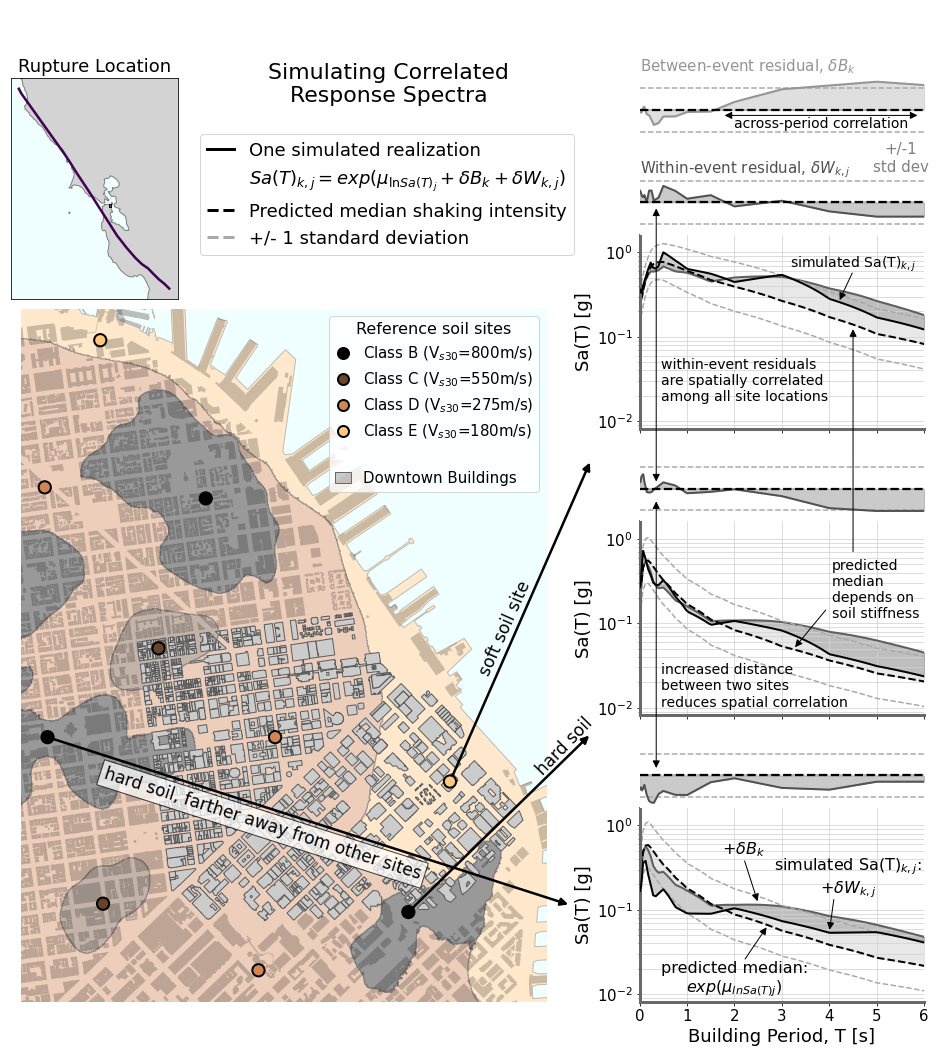

In [55]:
gm_idx = [0]

# list sites for displaying the response spectra, in order from top to bottom
site_list = [8,5,2]  # two B sites and one E
for i_sim in gm_idx:
    print(i_sim)
    figure_for_isim_with_context(i_sim, site_list)
    
fig_filename = 'gm_simulation_correlation_class_bd'
plt.savefig('figures_png/'+fig_filename+'.png', dpi=300, bbox_inches='tight');
plt.savefig('figures_pdf/'+fig_filename+'.pdf', bbox_inches='tight');